In [1]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
%matplotlib inline

# Helper functions

In [2]:
def imread(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def imshow(img, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.show()
    
def rgb2bin(img_rgb):
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    t, img_bin = cv2.threshold(
        img_gray, 0, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV
    )
    return img_bin

def find_best_contour(img_rgb):
    img_bin = rgb2bin(img_rgb)
    contours, h = cv2.findContours(
        img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )
    best_contour = max(contours, key=cv2.contourArea)
    return best_contour

def chain_hist(img_rgb):

    best_contour = find_best_contour(img_rgb)
    
    lookup_table = {
        (1, 0): 0,
        (1, -1): 1,
        (0, -1): 2,
        (-1, -1): 3,
        (-1, 0): 4,
        (-1, 1): 5,
        (0, 1): 6,
        (1, 1): 7
    }

    hist = np.zeros((8,))
    for i in range(len(best_contour)-1):
        pt1 = best_contour[i][0]
        pt2 = best_contour[i+1][0]
        dx = pt2[0] - pt1[0]
        dy = pt2[1] - pt1[1]
        code = lookup_table[(dx, dy)]
        hist[code] += 1

    return hist/hist.sum()

def draw_contours(img, contours, index=-1, color=(255, 0, 0), thickness=2):
    img_copy = img.copy()
    cv2.drawContours(img_copy, contours, index, color, thickness)
    imshow(img_copy)
    
def putText(img, contour, text):
    extLeft = tuple(contour[contour[:, :, 0].argmin()][0])
    extRight = tuple(contour[contour[:, :, 0].argmax()][0])
    extTop = tuple(contour[contour[:, :, 1].argmin()][0])
    extBot = tuple(contour[contour[:, :, 1].argmax()][0])
    x_min , x_max , y_max, y_min = extLeft[0] , extRight[0] , extBot[1] , extTop[1]
    
    
    cv2.putText(img, text, (x_min,y_min-5), cv2.FONT_HERSHEY_SIMPLEX , 0.5, 
                  (0, 0, 255), 1, cv2.LINE_AA, False)

# Using Support Vector Machine for shape classification

## Creating a DataFrame for our dataset

In [3]:
def create_df(data_path):
    
    # the class_dict is a mapping between class name and value
    class_dict = {
        'circle': 0,
        'square': 1,
        'star': 2,
        'triangle': 3
    }
    
    # we store image paths and outputs here
    df = []
    
    # for each class
    for class_name, class_value in class_dict.items():
        class_folder = os.path.join(data_path, class_name)
        # for each image in class folder
        for f in os.listdir(class_folder):
            f_path = os.path.join(class_folder, f)
            # if this is a "png" file, add its path and output
            if f_path.lower().endswith('.png'):
                df.append([f_path, class_value])
    
    # create a dataframe of image paths and outputs
    df = pd.DataFrame(df, columns=['path', 'output'])
    
    return df

In [4]:
data = create_df(r'archive\shapes')
data

,path,output
0,archive\shapes\circle\0.png,0
1,archive\shapes\circle\1.png,0
2,archive\shapes\circle\10.png,0
3,archive\shapes\circle\100.png,0
4,archive\shapes\circle\1000.png,0
...,...,...
14965,archive\shapes\triangle\995.png,3
14966,archive\shapes\triangle\996.png,3
14967,archive\shapes\triangle\997.png,3
14968,archive\shapes\triangle\998.png,3


## Extracting features

In [5]:
def extract_features(img_paths):
    n = len(img_paths)
    X = np.zeros((n, 8))
    for i in tqdm(range(n)):
        f_path = img_paths[i]
        img = imread(f_path)
        features = chain_hist(img)
        X[i] = features
    return X

In [6]:
X = extract_features(data['path'])

100%|███████████████████████████████████████████████████████████████████████████| 14970/14970 [00:21<00:00, 685.81it/s]


In [7]:
X[0:3]

array([[0.18541033, 0.0668693 , 0.17325228, 0.07902736, 0.17629179,
        0.06079027, 0.19148936, 0.0668693 ],
       [0.18292683, 0.07012195, 0.17073171, 0.07926829, 0.17682927,
        0.06097561, 0.19207317, 0.06707317],
       [0.18960245, 0.06422018, 0.17737003, 0.0795107 , 0.16819572,
        0.07033639, 0.18348624, 0.06727829]])

In [8]:
y = data['output']

## Splitting dataset

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=0
)

## Training

In [10]:
model = SVC()
model.fit(X_train, y_train)

SVC()

## Calculating accuracy

In [11]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.9370168909247065
0.9423291026497439


## Testing with images outside the dataset

In [12]:
def test_model(model, img_path):
    classes = ['circle', 'square', 'star', 'triangle']
    img = imread(img_path)
    x = chain_hist(img)
    c = model.predict([x])[0]
    print(img_path, '->', classes[c])

In [13]:
test_model(model, 'images/square.png')
test_model(model, 'images/star.png')
test_model(model, 'images/circle.png')
test_model(model, 'images/triangle.png')
test_model(model, 'images/square-hollow.png')
test_model(model, 'images/star-hollow.png')
test_model(model, 'images/circle-hollow.png')
test_model(model, 'images/triangle-hollow.png')

images/square.png -> square
images/star.png -> star
images/circle.png -> square
images/triangle.png -> triangle
images/square-hollow.png -> square
images/star-hollow.png -> star
images/circle-hollow.png -> square
images/triangle-hollow.png -> triangle


# Object detection example

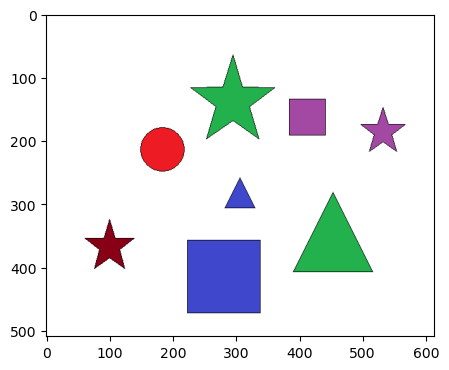

In [14]:
img = imread('images/shapes.png')
imshow(img)

In [15]:
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gray_inverted = cv2.bitwise_not(imgray)

ret, thresh = cv2.threshold(gray_inverted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)


cv2.drawContours(img, contours, -1, (0, 255, 0), 2) # -1 mean all contours   3 thickness 


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [16]:
def chain_hist(best_contour):

    lookup_table = {
        (1, 0): 0,
        (1, -1): 1,
        (0, -1): 2,
        (-1, -1): 3,
        (-1, 0): 4,
        (-1, 1): 5,
        (0, 1): 6,
        (1, 1): 7
    }

    hist = np.zeros((8,))
    for i in range(len(best_contour)-1):
        pt1 = best_contour[i][0]
        pt2 = best_contour[i+1][0]
        dx = pt2[0] - pt1[0]
        dy = pt2[1] - pt1[1]
        code = lookup_table[(dx, dy)]
        hist[code] += 1

    return hist/hist.sum()

In [17]:
X = np.zeros((len(contours), 8))
cnt = 0
for i in contours:
    features = chain_hist(i)
    X[cnt] = features
    cnt += 1

In [18]:
classes = ['circle', 'square', 'star', 'triangle']
img_copy = img.copy()

for i in range(len(X)):
    c = model.predict([X[i]])[0]
    putText(img_copy, contours[i], classes[c])

cv2.imshow('Image', img_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()